<a href="https://colab.research.google.com/github/rodrigomdc/cnn-esp32-electrical-device-ident/blob/main/Rede_Neural_Convolucional_Embarcada_para_a_Identifica%C3%A7%C3%A3o_de_Aparelhos_El%C3%A9tricos_em_uma_Resid%C3%AAncia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BIBLIOTECAS

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.python.ops.numpy_ops import np_config

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, classification_report

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import math
import os.path
import time

## PRÉ-PROCESSAMENTO DOS DADOS


### CARREGAMENTO DA BASE DE DADOS


In [48]:
data = pd.read_csv('https://raw.githubusercontent.com/rodrigomdc/cnn-esp32-electrical-device-ident/main/data/current_data.csv', sep = ',', header= None)
data = data.astype('float32')
cp_data = data.copy()

x = cp_data.iloc[0:, 0:214]
y = cp_data.iloc[:, 214]

## ANALISE DOS DADOS

### GRAFICOS DE CORRENTE ALTERNADA PARA CADA DISPOSITIVO NA BASE

#### FUNÇÕES DE CONVERSÃO

In [5]:
def currentPerSample(sample):
  val_calibration = 90.9090
  gain = 1.0
  current = ((val_calibration * gain) * sample)/ 1000.0
  return current

def currentRMS(sample):
    val_calibration = 90.9090
    gain = 1.0
    sum = 0
    for s in sample:
      sum = sum + s ** 2
    return ((val_calibration * gain) * math.sqrt(sum/len(sample))) / 1000.0

#### GRAFICO: CARREGADOR NOTEBOOK LENOVO


##### CORRENTE POR AMOSTRAS




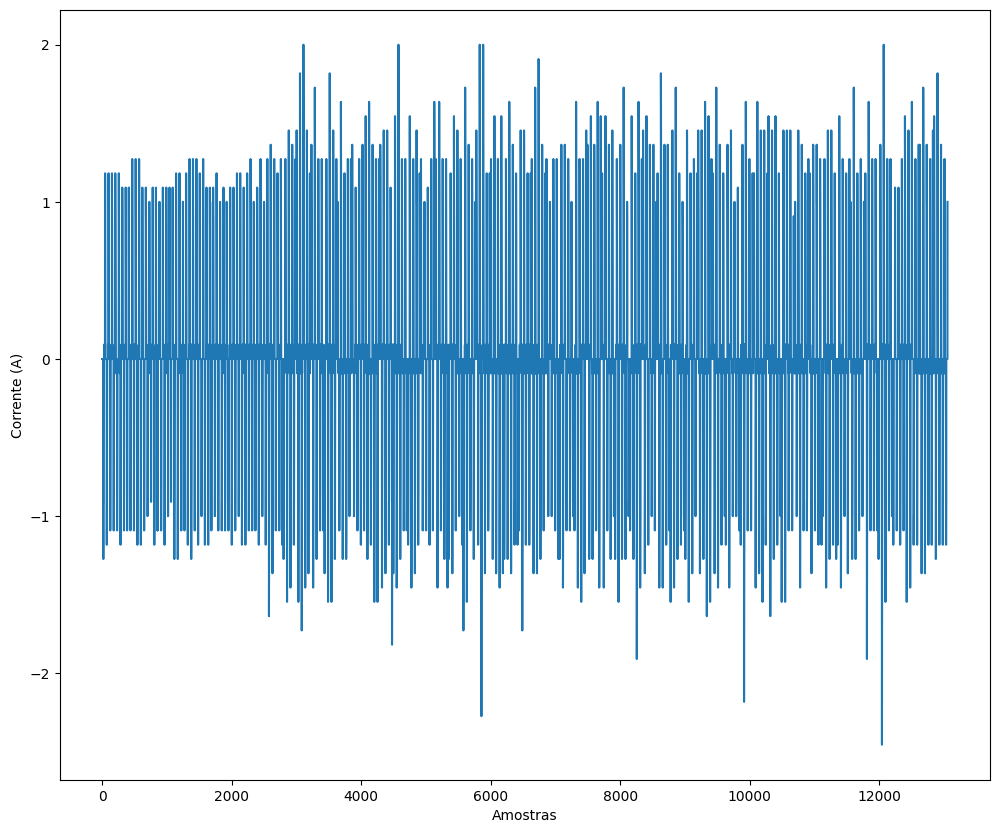

In [16]:
plt.figure(figsize=(12,10))
plt.plot(range(0,cp_data.iloc[0:61, 0:214].size), currentPerSample(cp_data.iloc[0:61, 0:214]).values.reshape(-1))
plt.xlabel('Amostras')
plt.ylabel("Corrente (A)")
plt.tick_params(axis='both')
plt.show()

#### GRAFICO: ESCOVA TERMICA - VELOCIDADE 1

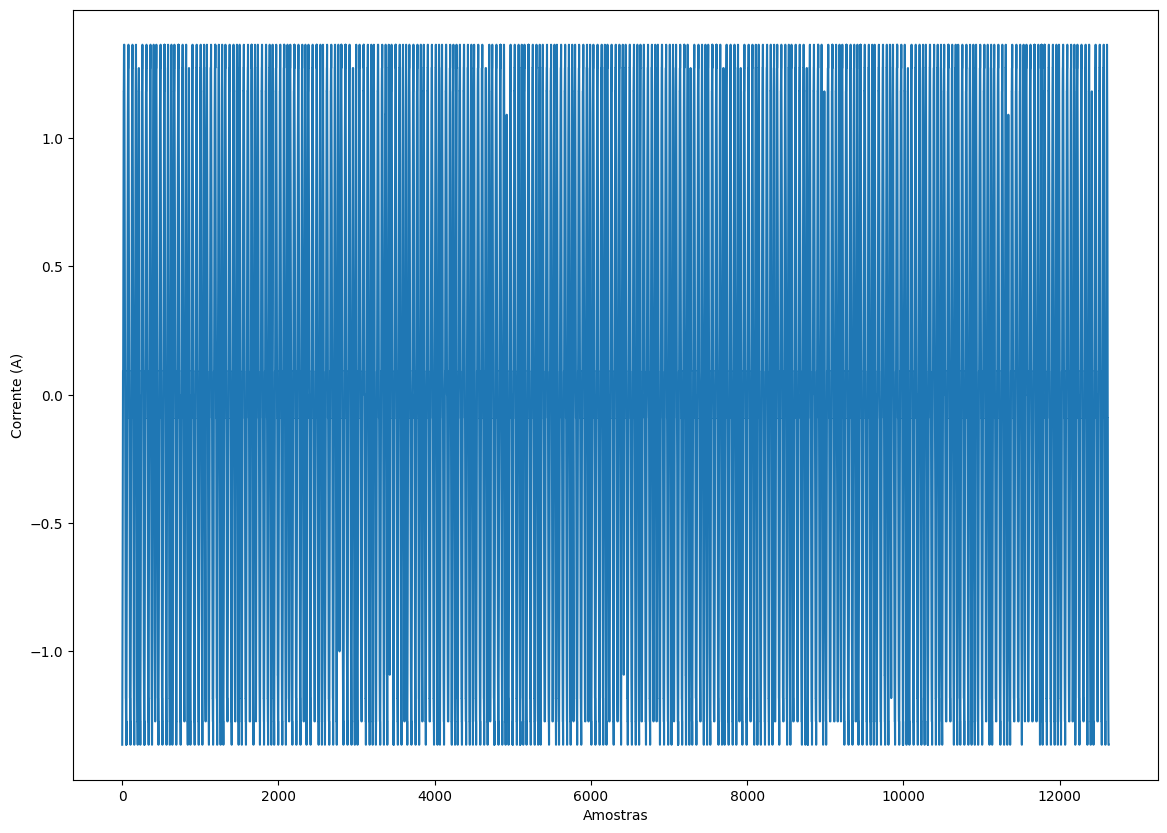

In [17]:
plt.figure(figsize=(14,10))
plt.plot(range(0,cp_data.iloc[431:490, 0:214].size), currentPerSample(cp_data.iloc[431:490, 0:214]).values.reshape(-1))
plt.xlabel("Amostras")
plt.ylabel("Corrente (A)")
plt.show()

#### GRAFICO: ESCOVA TERMICA - VELOCIDADE 2

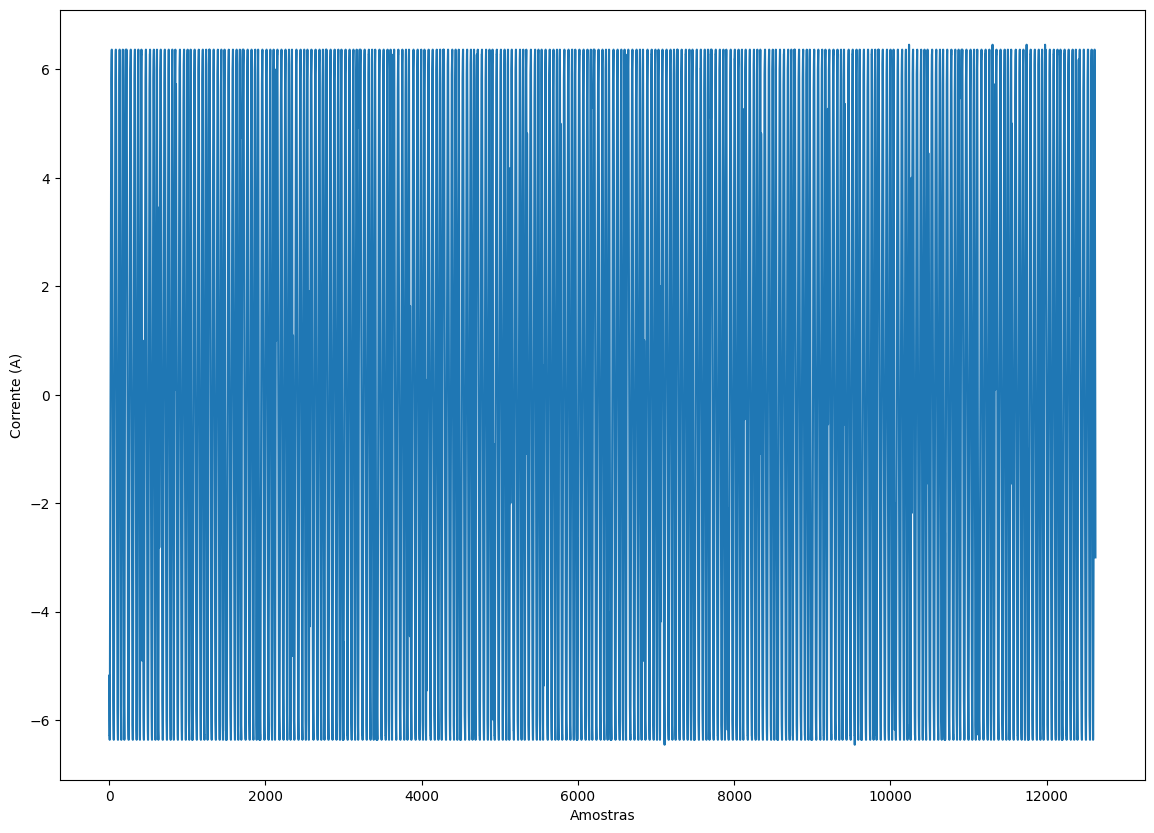

In [18]:
plt.figure(figsize=(14,10))
plt.plot(range(0,cp_data.iloc[861:920, 0:214].size), currentPerSample(cp_data.iloc[861:920, 0:214]).values.reshape(-1))
plt.xlabel("Amostras")
plt.ylabel("Corrente (A)")
plt.show()

#### GRAFICO: ESCOVA TERMICA - VELOCIDADE 3

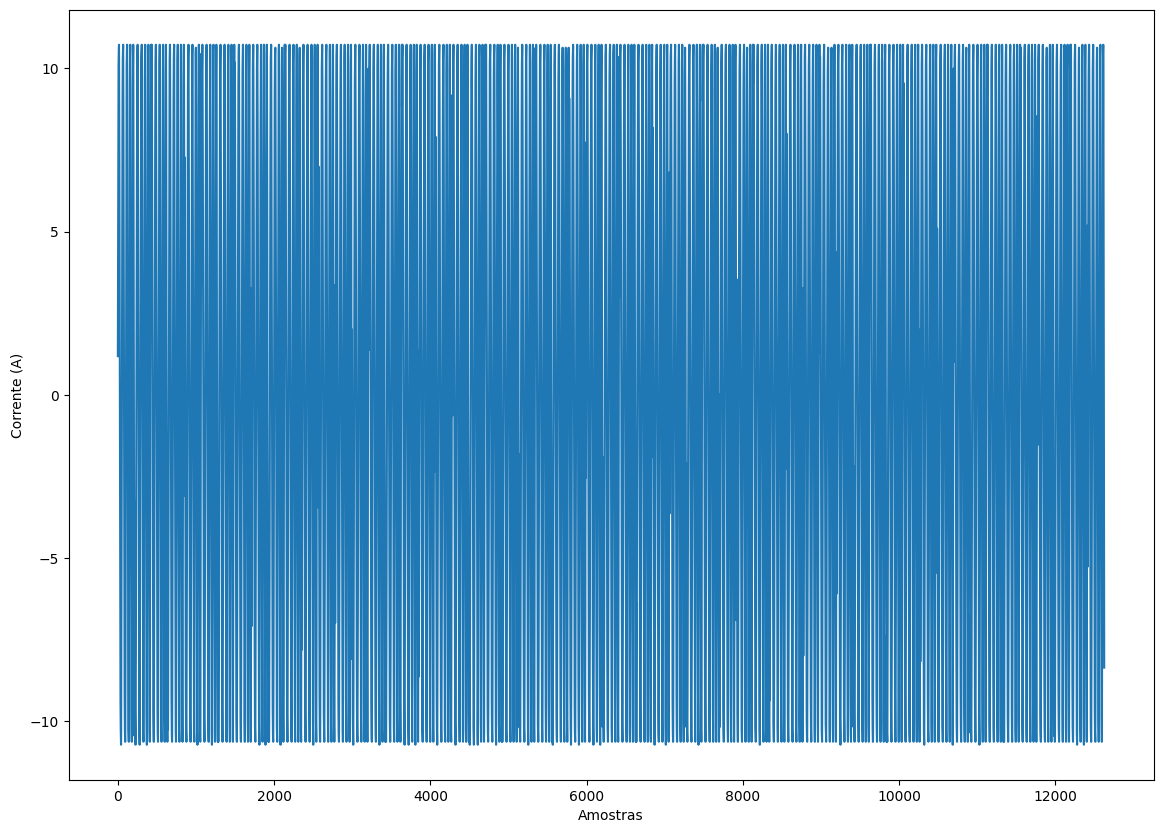

In [19]:
plt.figure(figsize=(14,10))
plt.plot(range(0,cp_data.iloc[1291:1350, 0:214].size), currentPerSample(cp_data.iloc[1291:1350, 0:214]).values.reshape(-1))
plt.xlabel("Amostras")
plt.ylabel("Corrente (A)")
plt.show()

#### GRAFICO: DESCONECTADO

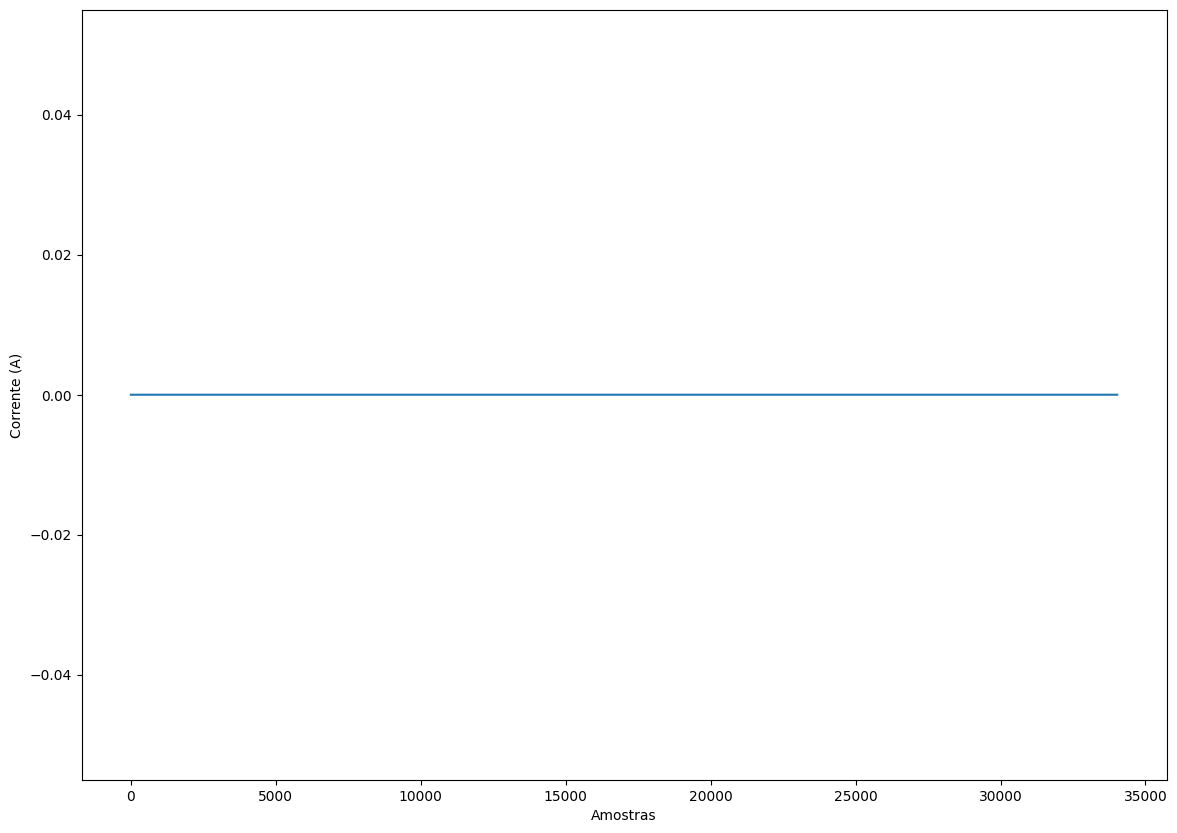

In [20]:
plt.figure(figsize=(14,10))
plt.plot(range(0,cp_data.iloc[1721:1880, 0:214].size), currentPerSample(cp_data.iloc[1721:1880, 0:214]).values.reshape(-1))
plt.xlabel("Amostras")
plt.ylabel("Corrente (A)")
plt.show()

#### GRAFICO: CARREGADOR DE IPHONE

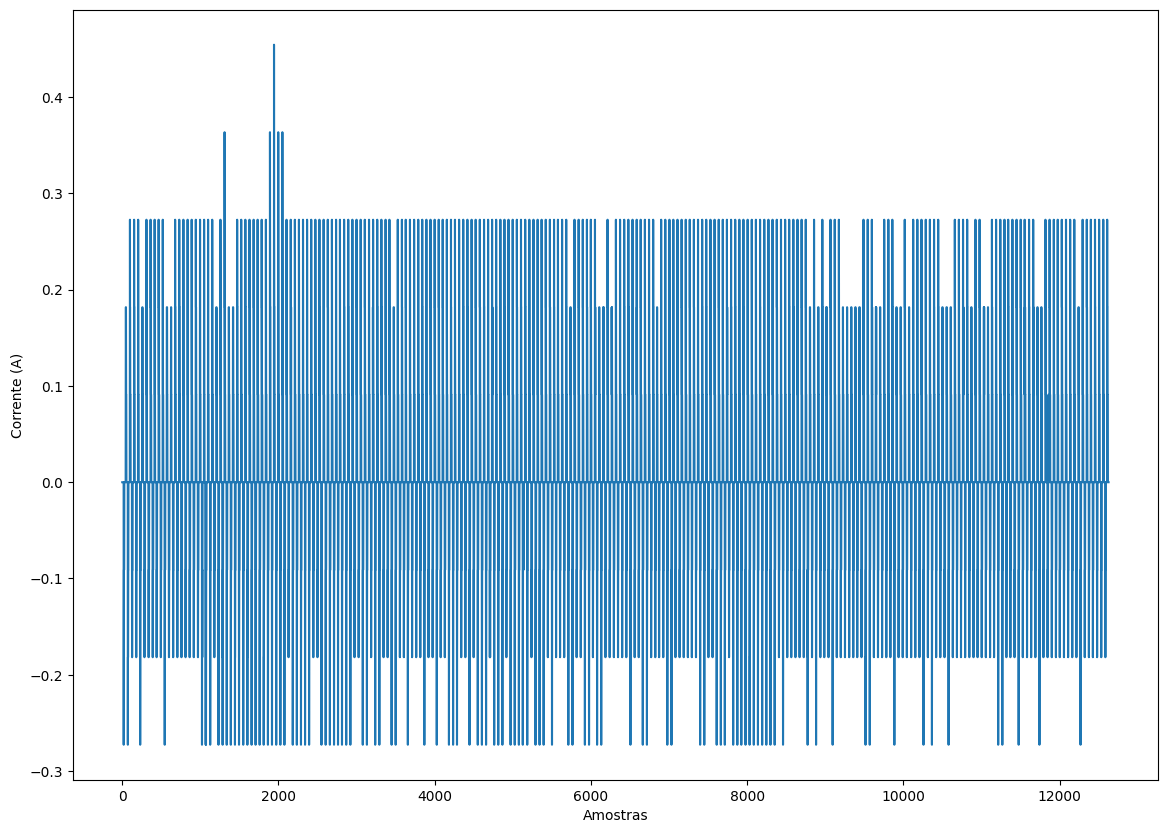

In [21]:
plt.figure(figsize=(14,10))
plt.plot(range(0,cp_data.iloc[2151:2210, 0:214].size), currentPerSample(cp_data.iloc[2151:2210, 0:214]).values.reshape(-1))
plt.xlabel("Amostras")
plt.ylabel("Corrente (A)")
plt.show()

#### GRAFICO: VENTILADOR DE MESA - VELOCIDADE 3

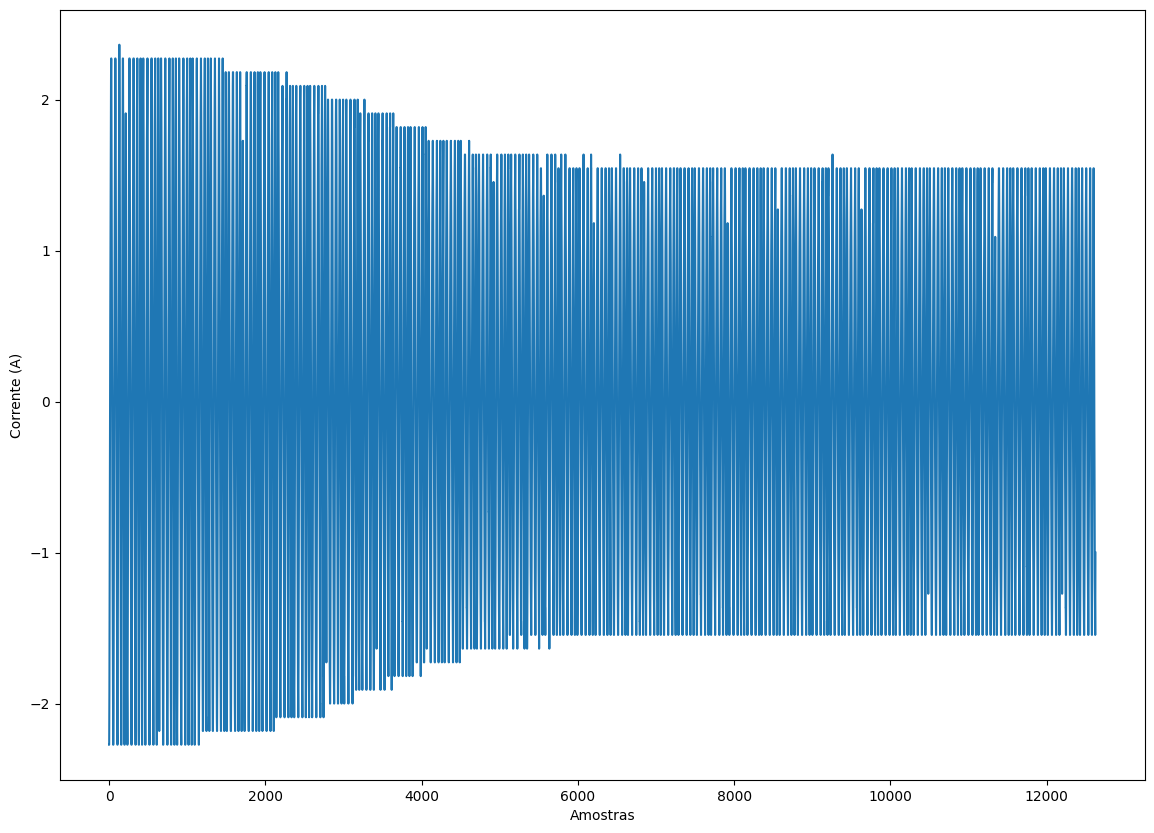

In [22]:

plt.figure(figsize=(14,10))
plt.plot(range(0,cp_data.iloc[2581:2640, 0:214].size), currentPerSample(cp_data.iloc[2581:2640, 0:214]).values.reshape(-1))
plt.xlabel("Amostras")
plt.ylabel("Corrente (A)")
plt.show()

#### GRAFICO: VENTILADOR DE MESA - VELOCIDADE 2

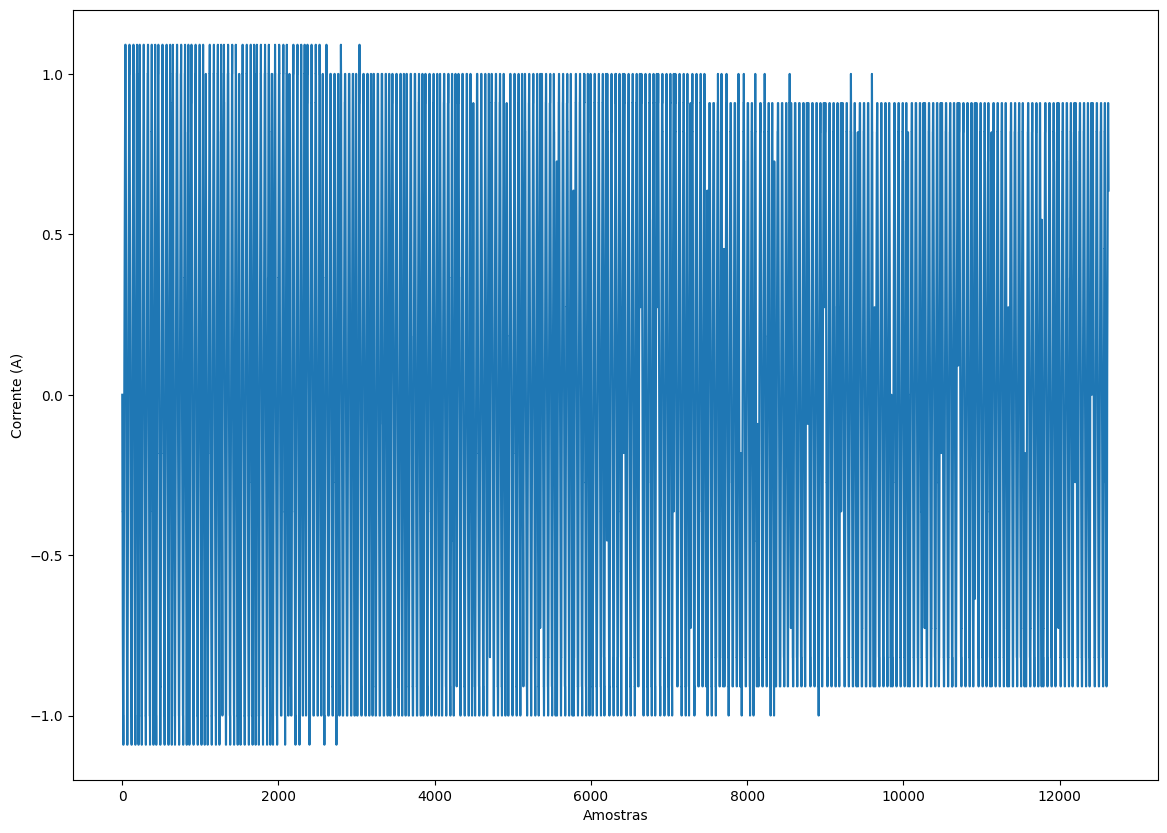

In [23]:
plt.figure(figsize=(14,10))
plt.plot(range(0,cp_data.iloc[3011:3070, 0:214].size), currentPerSample(cp_data.iloc[3011:3070, 0:214]).values.reshape(-1))
plt.xlabel("Amostras")
plt.ylabel("Corrente (A)")
plt.show()

#### GRAFICO: VENTILADOR DE MESA - VELOCIDADE 1

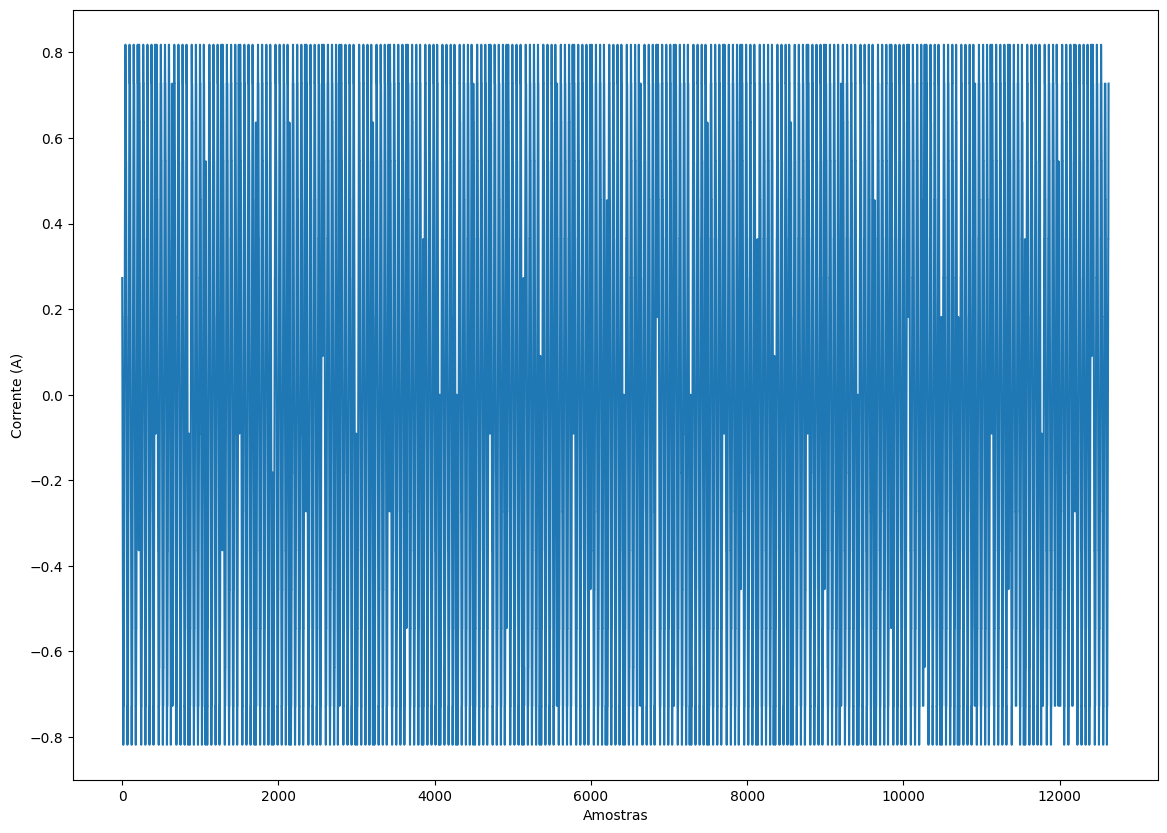

In [24]:
plt.figure(figsize=(14,10))
plt.plot(range(0,cp_data.iloc[3441:3500, 0:214].size), currentPerSample(cp_data.iloc[3441:3500, 0:214]).values.reshape(-1))
plt.xlabel("Amostras")
plt.ylabel("Corrente (A)")
plt.show()

## MODELAGEM

##### SEPARAÇÃO ENTRE TREINO E TESTE

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)
x_train = tf.reshape(x_train.values[:, 0:214], (x_train.shape[0], x_train.shape[1], 1)) #(432, 214, 1)
x_test = tf.reshape(x_test.values[:, 0:214], (x_test.shape[0], x_test.shape[1], 1)) #(432, 214, 1)

##### ARQUITETURA DA REDE

In [26]:
def setupModel():
    time_periods, num_features =  x_train.shape[1], x_train.shape[2]

    model = Sequential()    
    model.add(Conv1D(8, kernel_size=3, padding='same', activation='tanh', input_shape=(time_periods, num_features))) 
    model.add(Conv1D(8, kernel_size=3, padding='same', activation='tanh'))    
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())

    model.add(Conv1D(16, kernel_size=3, padding='same', activation='tanh'))     
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())

    model.add(Conv1D(32, kernel_size=3, padding='same', activation='tanh'))          
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='tanh'))     
    model.add(Dense(10, activation='softmax'))
    return model

###### CROSS VALIDATION - K-FOLD

In [30]:
def get_callbacks(patience_lr):
  
  mcp_save = ModelCheckpoint(
          filepath='best_model.accuracy-{accuracy:.2f}-val_loss-{val_loss:.7f}.h5',
          monitor='val_loss', 
          save_best_only=True,
          save_weights_only=False)

  ear_stop = EarlyStopping(
          monitor='accuracy', 
          patience=patience_lr,
          verbose=0
          )    
  ln_decay = LearningRateScheduler(
          lr_time_based_decay, 
          verbose=0)
  
  return [mcp_save, ear_stop, ln_decay]

In [28]:
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [ ]:
epochs=50
batch_size=32 
n_folds=10
patience=5

initial_learning_rate = 0.001
decay = initial_learning_rate / epochs

callbacks_list = get_callbacks(patience)
os.system("rm *best_model*") 

model_history = []
cv_scores = []
cv_loss = []
fold = 0

setupModel().summary()

for train_index,test_index in KFold(n_folds, shuffle=True, random_state=101).split(x, y):
  fold+=1
  
  x_train = x.iloc[train_index]
  x_val   = x.iloc[test_index]
  y_train = y.iloc[train_index]
  y_val   = y.iloc[test_index]  

  x_train = tf.reshape(x_train.values[:, 0:214], (x_train.shape[0], x_train.shape[1], 1)) 
  x_val = tf.reshape(x_val.values[:, 0:214], (x_val.shape[0], x_val.shape[1], 1)) 
   
  model = setupModel() 
 
  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer="adam", 
                metrics=['accuracy'])
  
  result = model.fit(x_train, 
          y_train, 
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks=callbacks_list,
          validation_data=(x_val, y_val),
          verbose=0)
  
  eval = model.evaluate(x_val, y_val, verbose=0);  

  print(f"Fold[{fold}] - Acurácia: {eval[1]*100} - Perda: {eval[0]}")
  model_history.append(result)
  cv_scores.append(eval[1]*100)
  cv_loss.append(eval[0])

print("\nAcurácia:")
print(f"Média: {np.mean(cv_scores)} - Desvio Padrão: {np.std(cv_scores)}\n")

print("Perda:")
print(f"Média: {np.mean(cv_loss)} - Desvio Padrão: {np.std(cv_loss)}\n")

##### AVALIAÇÃO DE DESEMPENHO DOS MODELOS

GRÁFICO: ACURÁCIA X PERDA

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
for i, eval in enumerate(model_history):
  ax1.plot(eval.history['accuracy'], "tab:green")
  ax1.plot(eval.history['val_accuracy'], "tab:orange", dashes=[3, 2])
  ax1.set_title("A", fontsize=13,loc='left')
  ax1.set_ylabel("Acurácia", fontsize=13)  
  ax1.set_xlabel('Épocas', fontsize=13)
  ax1.tick_params(axis='both', labelsize=11)
  ax1.legend(['Treino', 'Validação'], loc='best', fontsize=11)
  ax2.plot(eval.history['loss'], "tab:red")
  ax2.plot(eval.history['val_loss'], "tab:blue", dashes=[3, 2])
  ax2.set_title("B", fontsize=13,loc='left') 
  ax2.set_ylabel("Perda", fontsize=13) 
  ax2.set_xlabel('Épocas', fontsize=13)
  ax2.tick_params(axis='both', labelsize=11)
  ax2.legend(['Treino', 'Validação'], loc='best', fontsize=11)


#### AVALIAÇÃO DE DESEMPENHO DO MELHOR MODELO

In [34]:
model = tf.keras.models.load_model('best_model.<maior accuracy>-<meno val loss>.h5')

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("\nAcurácia para dados de teste: %0.2f" % score[1])
print("\nPerda para dados de teste: %0.2f" % score[0])

###### MATRIZ DE CONFUSÃO

In [ ]:
prediction = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test.values, prediction)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(cm, display_labels=np.unique(cp_data.values[:, 214]))
ax.set(title='Matriz de confusão - Modelo CNN')
display.plot(ax=ax);

###### RELATÓRIO DE CLASSIFICAÇÃO

In [ ]:
prediction = model.predict(x_test).argmax(axis=1)
print(classification_report(y_test, prediction))

## OPERAÇÕES COM TENSORFLOW LITE

### VISUALIZAÇÃO DO MODELO TFLITE

In [ ]:
#Importante para visualizar as operações do TFL que devem ser inseridas no sketch do código-fonte no ESP32
!python -m tensorflow.lite.tools.visualize model.tflite visualized_model.html

### CONVERSÃO PARA TENSORFLOW LITE

##### CONVERSÃO INTEIRA DE PESOS E ATIVAÇÕES

In [39]:
def representative_dataset():
    data = tf.data.Dataset.from_tensor_slices((x_train)).batch(214).take(int(len(x_train)))   
    for input in data: 
      yield [input]

In [40]:
def convertWeightsActivations():

  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset
  tflite_model = converter.convert()

  if(os.path.exists('/content/model.tflite')):
    os.remove('/content/model.tflite')

  with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

### TESTE PÓS CONVERSÃO TFLITE

#### CONVERSÃO INTEIRA DE PESOS E ATIVAÇÕES

In [41]:
def testConvertWeightActivation():
  assert os.path.exists('/content/model.tflite') == True
  np_config.enable_numpy_behavior()

  interpreter = tf.lite.Interpreter("model.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Test model on some input data.
  input_shape = input_details[0]['shape']
  acc=0
  total_infer_time=0
  ls_inference = []

  for i in range(len(x_test)):  
    input_data = x_test[i].reshape(input_shape)    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    start = time.time()
    interpreter.invoke()
    end = time.time()    
    output_data = interpreter.get_tensor(output_details[0]['index']) 
    ls_inference.append(output_data)
    if(np.argmax(output_data) == y_test.iloc[i, ]):
        acc+=1
    total_infer_time+=(end-start)    
  acc = (acc/len(x_test))*100
  total_infer_time = (total_infer_time/len(x_test))
  return acc, total_infer_time, ls_inference


#### EXECUÇÃO DOS TESTES

In [ ]:
#Conversion
convertWeightsActivations()

#Test
acc_wa, inf_time_wa, prediction_wa = testConvertWeightActivation()

print("Quantização inteira de pesos e ativações:")
print("Precisão média: ", acc_wa)
print("Tempo médio de inferência (s): ",inf_time_wa)

#### TAMANHO EM BYTES

In [ ]:
model_tf_size = os.path.getsize("/content/best_model.<maior accuracy>-<meno val loss>.h5")
model_tfl_size = os.path.getsize("/content/model.tflite")

print(f"Tamanho do modelo original: {model_tf_size} bytes")
print(f"Tamanho do modelo convertido: {model_tfl_size} bytes")

#### MATRIZ DE CONFUSÃO DO MODELO TFLITE

##### QUANTIZAÇÃO DE PESOS E ATIVAÇÕES

In [ ]:
cm_wa = confusion_matrix(y_test.values, np.asarray(prediction_wa).argmax(axis=-1))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(cm_wa, display_labels=np.unique(cp_data.values[:, 214]))
ax.set(title='Matriz de confusão - Quantização de Pesos e Ativações')
display.plot(ax=ax);

#### RELATÓRIO DE CLASSIFICAÇÃO


##### CONVERSÃO COM QUANTIZAÇÃO DE PESOS E ATIVAÇÕES

In [ ]:
print(classification_report(y_test, np.asarray(prediction_wa).argmax(axis=-1)))

## CONVERSÃO DO MODELO PARA FORMATO ARDUINO

#### PACOTE DE CONVERSÃO

In [ ]:
# Install xxd if it is not available
!apt-get -qq install xxd

#### CONVERSÃO EM C++ ARDUINO

In [ ]:
if(os.path.exists('/content/model.h')):
  os.remove('/content/model.h')

!echo "const unsigned char model[] = {" > /content/model.h
!cat model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Arquivo model.h, tem {model_h_size:,} bytes.")